In [93]:
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from keras import layers, models
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import (Input, Dense, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D)
import matplotlib.pyplot as plt
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense


In [94]:
def load_data_pathmnist():
    path = r"C:\Users\clara\Documents\uni\4thYear_AMLS\Datasets\pathmnist.npz"
    #path = r"Datasets\pathmnist.npz"
    with np.load(path) as pathmnistmnist:
        x_train = pathmnistmnist['train_images']
        y_train = pathmnistmnist['train_labels']
        x_val = pathmnistmnist['val_images']
        y_val = pathmnistmnist['val_labels']
        x_test = pathmnistmnist['test_images']
        y_test = pathmnistmnist['test_labels']

    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))

((x_train, y_train), (x_val, y_val), (x_test, y_test)) = load_data_pathmnist()


In [95]:
# Define a dictionary that maps class labels to their names
class_label_names = {
    '0': 'adipose',
    '1': 'background',
    '2': 'debris',
    '3': 'lymphocytes',
    '4': 'mucus',
    '5': 'smooth muscle',
    '6': 'normal colon mucosa',
    '7': 'cancer-associated stroma',
    '8': 'colorectal adenocarcinoma epithelium'
}

# Function to print class label descriptions - this function is called in plot_class_distribution_pathmnist(y_train, y_val, y_test)
# to provide more information about the names of each class
def print_class_label_descriptions(class_label_names):
    print("Class Label Descriptions:")
    for label, name in class_label_names.items():
        print(f"Class {label}: {name}")

Class Label Descriptions:
Class 0: adipose
Class 1: background
Class 2: debris
Class 3: lymphocytes
Class 4: mucus
Class 5: smooth muscle
Class 6: normal colon mucosa
Class 7: cancer-associated stroma
Class 8: colorectal adenocarcinoma epithelium


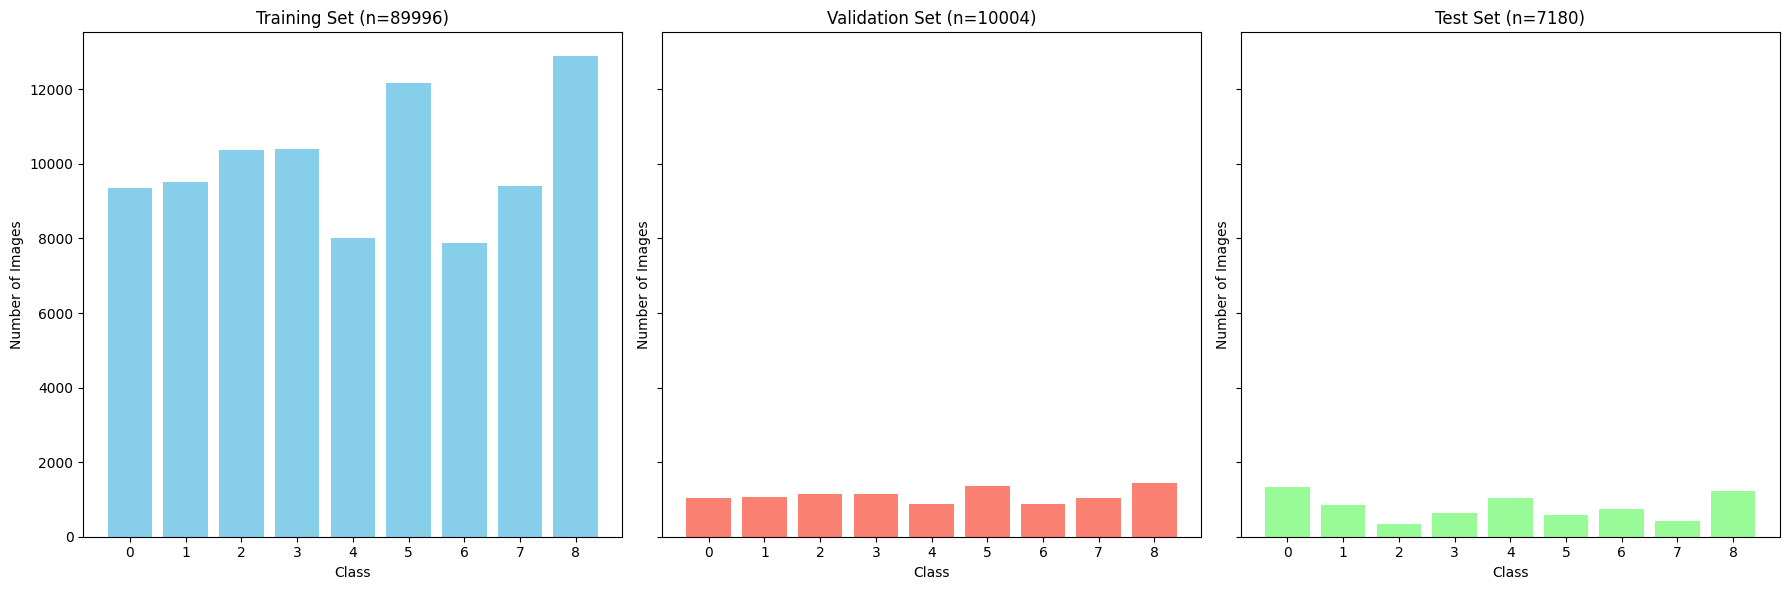

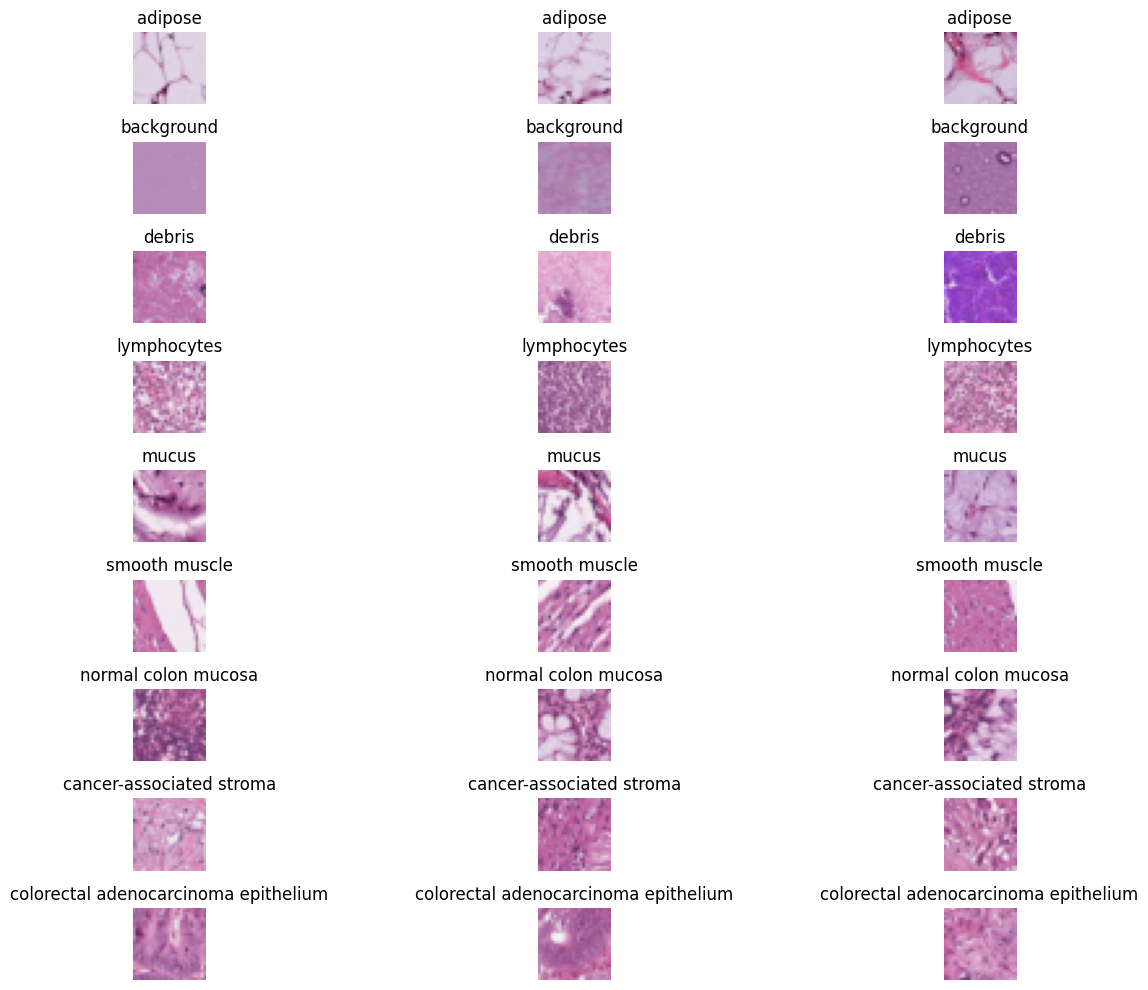

: 

In [96]:
def plot_class_distribution_pathmnist(y_train, y_val, y_test):

    print_class_label_descriptions(class_label_names)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    datasets = [y_train, y_val, y_test]
    titles = ['Training Set', 'Validation Set', 'Test Set']
    colors = ['skyblue', 'salmon', 'palegreen']  

    for i, (dataset, title, color) in enumerate(zip(datasets, titles, colors)):
        classes, counts = np.unique(dataset, return_counts=True)
        axes[i].bar(classes, counts, color=color)
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel('Number of Images')
        axes[i].set_xticks(classes)
        axes[i].set_title(f"{title} (n={len(dataset)})")  # Show the number of samples in the title

    plt.tight_layout()
    plt.show()

plot_class_distribution_pathmnist(y_train, y_val, y_test)
        

def show_sample_images(x_data, y_data, class_label_names, num_samples_per_class=3, num_classes=9):
   
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 10))

    for class_label in range(num_classes):
        class_indices = np.where(y_data == class_label)[0]
        sampled_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        for sample_idx, data_idx in enumerate(sampled_indices):
            image = x_data[data_idx].reshape(28, 28, 3)  # Assuming RGB images
            axes[class_label, sample_idx].imshow(image)
            axes[class_label, sample_idx].axis('off')
            axes[class_label, sample_idx].set_title(class_label_names[str(class_label)])

    plt.tight_layout()
    plt.show()

show_sample_images(x_train, y_train, class_label_names)

In [90]:
def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
    # Normalize images
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val, num_classes=9)
    y_test = to_categorical(y_test, num_classes=9)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Preprocess the data
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [91]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with desired augmentations
data_generator = ImageDataGenerator(
    rotation_range=20,        # Degree range for random rotations
    width_shift_range=0.2,    # Range (as a fraction of total width) for horizontal shifts
    height_shift_range=0.2,   # Range (as a fraction of total height) for vertical shifts
    horizontal_flip=True,     # Randomly flip inputs horizontally
    vertical_flip=True,       # Randomly flip inputs vertically
    # You can add more augmentations as needed
)

# Note: Do not apply augmentation to validation or test data
# Assuming x_train, y_train, x_val, y_val are already defined and preprocessed

# Apply augmentation to training data
train_generator = data_generator.flow(x_train, y_train, batch_size=128)


In [58]:
def create_model(input_shape, num_classes):
    model = Sequential([
        # Reduce the number of filters in convolutional layers
        Conv2D(8, kernel_size=3, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        # Reduced filters in second Conv2D layer
        Conv2D(16, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        # Reduced number of neurons in the dense layer
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model(x_train.shape[1:], 9)

# Print the model summary
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 8)         224       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 16)      

In [64]:
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
              loss=CategoricalCrossentropy(from_logits=False),  # Set from_logits to False
              metrics=['accuracy'])


# # Train the model with early stopping
# history = model.fit(
#     x_train, y_train, 
#     batch_size=128, 
#     epochs=10, 
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping]  # Include the early stopping callback

    # Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(x_val, y_val),  # No augmentation for validation data
    steps_per_epoch=len(x_train) // 128,  # Number of batches per epoch
    # Include other parameters like callbacks if needed
)

# Save the model
model.save('pathmnist_model.h5')


Epoch 1/15
703/703 [==============================] - 19s 27ms/step - loss: 0.9038 - accuracy: 0.6668 - val_loss: 1.0679 - val_accuracy: 0.6022
Epoch 2/15
703/703 [==============================] - 19s 27ms/step - loss: 0.8826 - accuracy: 0.6728 - val_loss: 1.2481 - val_accuracy: 0.5608
Epoch 3/15
703/703 [==============================] - 18s 26ms/step - loss: 0.8700 - accuracy: 0.6802 - val_loss: 1.0316 - val_accuracy: 0.6171
Epoch 4/15
703/703 [==============================] - 19s 28ms/step - loss: 0.8624 - accuracy: 0.6839 - val_loss: 1.1917 - val_accuracy: 0.5785
Epoch 5/15
703/703 [==============================] - 18s 26ms/step - loss: 0.8513 - accuracy: 0.6862 - val_loss: 1.5634 - val_accuracy: 0.5066
Epoch 6/15
703/703 [==============================] - 19s 27ms/step - loss: 0.8378 - accuracy: 0.6930 - val_loss: 1.1946 - val_accuracy: 0.5776
Epoch 7/15
703/703 [==============================] - 34s 49ms/step - loss: 0.8301 - accuracy: 0.6965 - val_loss: 1.4246 - val_accuracy:

In [65]:
# For making predictions
predictions = model.predict(x_test)

# For evaluating the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

225/225 [==============================] - 1s 2ms/step - loss: 1.7054 - accuracy: 0.4384
Test Accuracy: 43.84%


225/225 [==============================] - 1s 2ms/step
Predictions: [0 0 0 ... 0 0 0]
Accuracy on test set: 0.18635097493036212
Recall on test set: 0.1111111111111111


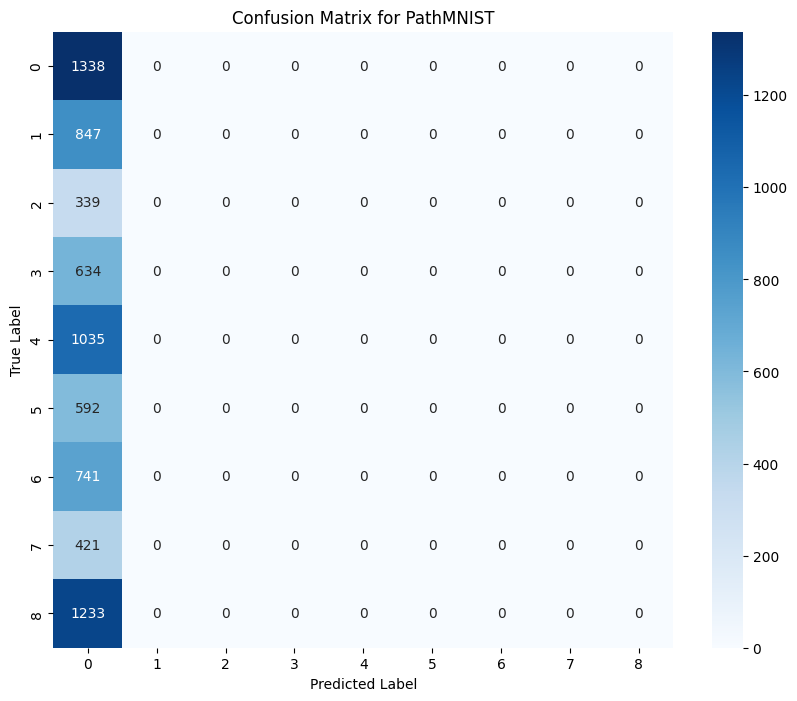

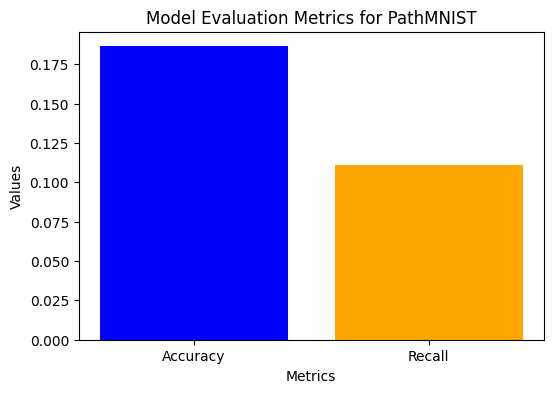

In [66]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import seaborn as sns
def pathmnist_model_predict(x_test, y_test, model_path):
    # Load the model
    model = load_model(model_path)

    # Preprocess the test data (assuming this matches your preprocessing)
    x_test = x_test.astype('float32') / 255

    # Ensure y_test is one-hot encoded
    y_test_onehot = to_categorical(y_test, num_classes=9)

    # Make predictions
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate accuracy and recall
    accuracy = accuracy_score(y_test.argmax(axis=1), predicted_classes)
    recall = recall_score(y_test.argmax(axis=1), predicted_classes, average='macro')

    # Print the predictions and evaluation metrics
    print("Predictions:", predicted_classes)
    print("Accuracy on test set:", accuracy)
    print("Recall on test set:", recall)

    # Create a confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), predicted_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for PathMNIST')
    plt.show()

    # Create a bar plot for accuracy and recall
    metrics = ['Accuracy', 'Recall']
    values = [accuracy, recall]
    plt.figure(figsize=(6, 4))
    plt.bar(metrics, values, color=['blue', 'orange'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Evaluation Metrics for PathMNIST')
    plt.show()

# Usage Example
pathmnist_model_predict(x_test, y_test, 'pathmnist_model.h5')

In [92]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU

def create_tinyvgg(input_shape, hidden_units, output_shape):
    model = Sequential()
    
    # Conv Block 1
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same', input_shape=input_shape))
    model.add(ReLU())
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=2))
    
    # Conv Block 2
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same'))
    model.add(ReLU())
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=2))

    # Classifier
    model.add(Flatten())
    model.add(Dense(output_shape))

    return model

# Create the Keras model
input_shape = (28, 28, 3)  # Replace with your actual input shape
n_classes = 9  # Number of classes
model = create_tinyvgg(input_shape, hidden_units=10, output_shape=n_classes)

# View the model summary
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 10)        280       
                                                                 
 re_lu_28 (ReLU)             (None, 28, 28, 10)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 10)        910       
                                                                 
 re_lu_29 (ReLU)             (None, 28, 28, 10)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 10)        910       
                                                     

In [87]:
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
              loss=CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])


In [88]:
from keras.callbacks import ModelCheckpoint

# Create a model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='./tinyvgg.h5',     # Path where to save the model
    save_best_only=True,         # Save only the best model
    monitor='val_loss',          # Metric to monitor
    mode='min'                   # Save the model with the minimum validation loss
)

In [89]:
# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[model_checkpoint]  # Include the checkpoint callback
)

Epoch 1/50
704/704 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.1041
Epoch 2/50
704/704 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1041 - val_loss: nan - val_accuracy: 0.1041
Epoch 3/50
704/704 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1041 - val_loss: nan - val_accuracy: 0.1041
Epoch 4/50
704/704 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.1041 - val_loss: nan - val_accuracy: 0.1041
Epoch 5/50
704/704 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1041 - val_loss: nan - val_accuracy: 0.1041
Epoch 6/50
704/704 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.1041 - val_loss: nan - val_accuracy: 0.1041
Epoch 7/50
704/704 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1041 - val_loss: nan - val_accuracy: 0.1041
Epoch 8/50
704/704 [============================

KeyboardInterrupt: 